In [1316]:
Der(state_array,1,4,initX)

LoadError: BoundsError: attempt to access 4007×5 Matrix{Float64} at index [0, 4]

# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


In [1823]:
# Parameters
m = 3

3

In [1824]:
res=m;
N=2.0^m*500.0;#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx*0.4,digits=10);
Nt=100.0*2^m*10
Tf=Nt*dt; #final time

println("the final time is ", Tf)

the final time is 0.8


In [1825]:
print(N)

4000.0

In [1826]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2) = ", dx/dt*(1/2)^(2))

dx =0.00025
dt =0.0001
dx/dt =2.5
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.3125
epsilon = dx/dt * (1/2)^(2*2) = 0.15625
epsilon = dx/dt * (1/2)^(2*3) = 0.0390625
epsilon = dx/dt * (1/2)^(2) = 0.625


In [1827]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res3"

In [1828]:
println(dx)
println(dt)

0.00025
0.0001


In [1829]:
epsilon=0.1##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

0.1

# Grid

In [1830]:
ori=0.0;
initX1 = nothing
initX1=range(ori, stop=Xf, step=dx);

In [1831]:
print(dx)
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf-dt,step=dt)
println("the time step is ", dt)

0.00025step size is  0.00025
the time step is 0.0001


In [1832]:
radius=zeros(L)
print(L)
print(size(initX1))
print(initX1[1001])
for i in 1:L
    radius[i]=initX[i]/(1-initX[i])
end


4007(4001,)0.25

In [1833]:
include("./ScalarField.jl");

In [1834]:
using Interpolations

# Initial data of m β Ψ and Ψ,x

In [1835]:
using PyCall   


scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")


####

initphi=zeros(L);
initphibar=zeros(L);

#PHI,X

r0=0.7#0.3
sigma=0.3
A=0.1449
initphibar[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)



#PHI FROM PSI,X
spl = scipyinterpolate.splrep(initX[4:L-3], initphibar[4:L-3],k=5)
phi0=0
SFconstraint_phi(phi0,x) = scipyinterpolate.splev(x, spl)
initphi[4:L-3], psi_ks = rungekutta4(SFconstraint_phi,phi0,initX1) 


#PHI
"initphi = init_gaussian(R,r0,sigma,A)"




"initphi = init_gaussian(R,r0,sigma,A)"

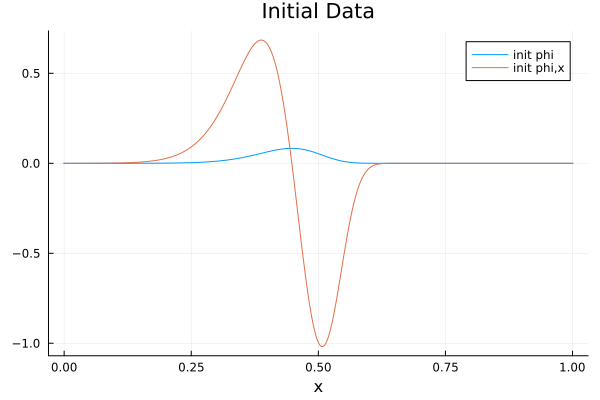

In [1836]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX, [initphi initphibar], xaxis="x",title="Initial Data", labels=["init phi" "init phi,x"])

In [1837]:
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initpsibar=zeros(L);
state_array=[initm initbeta initpsi initpsibar initX];


#PSI
"initpsi = initphi .* initX ./ (1 .- initX)
initpsi[L-3]=0
state_array[:,3]=initpsi;
state_array=ghost(state_array);"


#PSI,X
initpsibar = initphibar .* initX ./ (1 .- initX) +  initphi ./ (1 .- initX) .^2
initpsibar[L-3]=0
state_array[:,4]=initpsibar;
state_array=ghost(state_array);

spl_derpsi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,4],k=4)
derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)

#### PSI from PSI,X
spl = scipyinterpolate.splrep(initX[4:L-3], initpsibar[4:L-3],k=4)
psi0=0
SFconstraint_psi(psi0,x) = scipyinterpolate.splev(x, spl)
initpsi[4:L-3], psi_ks = rungekutta4(SFconstraint_psi,psi0,initX1)
state_array[:,3]=initpsi;
state_array=ghost(state_array);


psi_double_data = rungekutta4(SFconstraint_psi,psi0,doublegrid(initX1))[1]


#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,initX1,0,derpsi_func,psi_double_data)
state_array[:,2]=initbeta;
state_array=ghost(state_array);


#M
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,initX1,0,derpsi_func,psi_double_data)
state_array[:,1]=initm;
state_array=ghost(state_array);


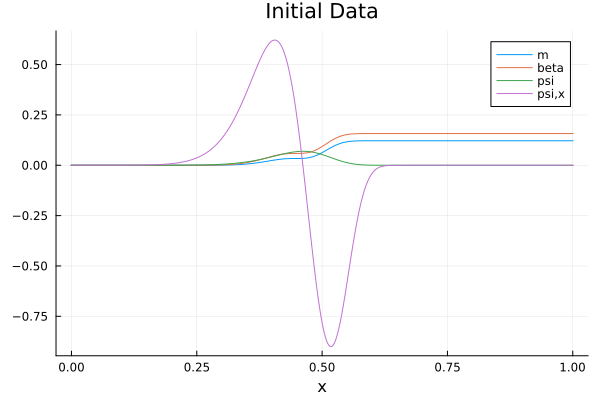

In [1838]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX, state_array[:,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.4, 1])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [1839]:
using CSV, Tables
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res3/time_step0.csv"

 ## Time evolution

fixed grid

In [1840]:
using Interpolations
using ProgressMeter
@showprogress for k in 1:10#length(T)

    #evolve psi,x
    state_array=rungekutta4molstep(SF_RHS,state_array,T,k,0,derpsi_func) #evolve psi,x
    state_array=ghost(state_array)
    
"    X=state_array[:,5]
    X1=X[4:L-3]
    
    #calculate psi from psi,x
    psi0=0
    spl_derpsi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,4],k=4)
    SFconstraint_psi(psi0,x) = scipyinterpolate.splev(x, spl_derpsi)
    
    state_array[4:L-3,3],psi_ks = rungekutta4(SFconstraint_psi,psi0,X1)
    state_array=ghost(state_array);

    psi_double_data = rungekutta4(SFconstraint_psi,psi0,doublegrid(initX1))[1]   
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,X1,0,derpsi_func,psi_double_data)
    state_array=ghost(state_array)
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=rk4wrapper(SFconstraint_m,m0,X1,0,derpsi_func,psi_double_data)
    state_array=ghost(state_array)
    "
    
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [1704]:
state_array[:,4]

4007-element Vector{Float64}:
  1.0361646045565206e-9
  4.6346543751566974e-10
  1.1659891136433515e-10
  0.0
  1.1810367732014755e-10
  4.75344917222261e-10
  1.0761586936038238e-9
  1.9250332807613106e-9
  3.026510779533425e-9
  4.385187648067311e-9
  6.00571523724532e-9
  7.892800330809893e-9
  1.0051205690224596e-8
  ⋮
 -9.57795908101507e-12
 -1.2509987371121722e-11
 -1.7027482810693457e-11
 -2.4519575247398577e-11
 -3.831183632406028e-11
 -6.810993124277383e-11
 -1.5324734529624111e-10
 -6.129893811849645e-10
  0.0
  3.133056837167596e-9
  1.0233517169226768e-8
  2.2748717035086457e-8

In [1705]:
y = state_array
X = state_array[:,5]

for i in 5:L-3
    println(i," ", Der(y,i,4,X))
end

5 9.477331851795333e-7
6 1.9131356165027e-6
7 2.89636660203304e-6
8 3.897657985530587e-6
9 4.917226131602169e-6
10 5.955289537215527e-6
11 7.012068850416495e-6
12 8.087786889197382e-6
13 9.182668660517463e-6
14 1.0296941379477372e-5
15 1.1430834488647607e-5
16 1.2584579677553398e-5
17 1.3758410902316019e-5
18 1.4952564405452915e-5
19 1.616727873583633e-5
20 1.7402794768813065e-5
21 1.8659355726486095e-5
22 1.9937207198157746e-5
23 2.1236597160940083e-5
24 2.255777600052656e-5
25 2.390099653213344e-5
26 2.526651402160851e-5
27 2.665458620670784e-5
28 2.8065473318542732e-5
29 2.9499438103200585e-5
30 3.095674584353706e-5
31 3.243766438114145e-5
32 3.394246413847868e-5
33 3.5471418141210316e-5
34 3.702480204068828e-5
35 3.860289413663344e-5
36 4.020597539999253e-5
37 4.183432949597609e-5
38 4.348824280728241e-5
39 4.5168004457503565e-5
40 4.687390633471949e-5
41 4.860624311528408e-5
42 5.036531228778709e-5
43 5.2151414177216235e-5
44 5.39648519693169e-5
45 5.580593173513227e-5
46 5.767496

408 0.00944329286015082
409 0.009534749724797426
410 0.00962700799245917
411 0.009720074118987902
412 0.009813954608294855
413 0.009908656012671093
414 0.010004184933119787
415 0.010100548019688243
416 0.010197751971802817
417 0.010295803538599988
418 0.010394709519263478
419 0.010494476763366062
420 0.010595112171210848
421 0.010696622694174117
422 0.010799015335046205
423 0.010902297148384834
424 0.011006475240863832
425 0.011111556771617362
426 0.011217548952602565
427 0.01132445904895115
428 0.011432294379325109
429 0.01154106231628118
430 0.011650770286629161
431 0.01176142577179393
432 0.011873036308187467
433 0.011985609487575183
434 0.012099152957439914
435 0.012213674421363575
436 0.012329181639399814
437 0.012445682428445915
438 0.012563184662623699
439 0.012681696273666452
440 0.012801225251297855
441 0.01292177964361504
442 0.013043367557479485
443 0.01316599715890989
444 0.01328967667347374
445 0.013414414386675356
446 0.01354021864435796
447 0.013667097853108356
448 0.013

833 0.3232171888391958
834 0.32556054865745965
835 0.32791928736974696
836 0.3302934919117946
837 0.3326832495788431
838 0.3350886480258886
839 0.33750977526788173
840 0.3399467196795386
841 0.3423995699955067
842 0.3448684153104176
843 0.3473533450788089
844 0.3498544491152668
845 0.35237181759414316
846 0.3549055410496518
847 0.3574557103758483
848 0.360022416826364
849 0.3626057520143766
850 0.36520580791243956
851 0.3678226768523779
852 0.370456451525012
853 0.37310722497988724
854 0.37577509062522696
855 0.3784601422276298
856 0.3811624739115731
857 0.38388218015935155
858 0.3866193558106538
859 0.38937409606206846
860 0.3921464964670691
861 0.3949366529351896
862 0.3977446617318422
863 0.4005706194778136
864 0.4034146231486591
865 0.40627677007442686
866 0.40915715793884305
867 0.41205588477898497
868 0.41497304898460846
869 0.41790874929731286
870 0.42086308481026485
871 0.4238361549673665
872 0.4268280595623339
873 0.4298388987383103
874 0.4328687729868339
875 0.435917783147164

1575 3.23071212396909
1576 3.1803428635622972
1577 3.129475223154822
1578 3.0781081991268744
1579 3.026240816973293
1580 2.973872131718323
1581 2.921001228290797
1582 2.8676272219322168
1583 2.813749258586739
1584 2.759366515307475
1585 2.704478200649445
1586 2.649083555074164
1587 2.593181851345648
1588 2.5367723949428598
1589 2.4798545244511896
1590 2.422427611978684
1591 2.3644910635478893
1592 2.306044319514898
1593 2.2470868549656338
1594 2.1876181801314125
1595 2.127637840788457
1596 2.0671454186717435
1597 2.0061405318842276
1598 1.9446228353040842
1599 1.882592020992291
1600 1.8200478186123512
1601 1.756989995829912
1602 1.69341835872942
1603 1.629332752222511
1604 1.5647330604664003
1605 1.4996192072653594
1606 1.4339911564903909
1607 1.367848912483163
1608 1.3011925204791062
1609 1.2340220670052644
1610 1.1663376803025158
1611 1.098139530731556
1612 1.0294278311849097
1613 0.9602028374969113
1614 0.8904648488567479
1615 0.8202142082134886
1616 0.7494513026908559
1617 0.678176

1994 -14.766078614555195
1995 -14.611864116149878
1996 -14.456469125753612
1997 -14.299906862892454
1998 -14.142190741801313
1999 -13.983334370264505
2000 -13.823351548329187
2001 -13.662256267118797
2002 -13.500062707423254
2003 -13.336785238425877
2004 -13.172438416234433
2005 -13.007036982471213
2006 -12.840595862773423
2007 -12.673130165261751
2008 -12.504655178938181
2009 -12.335186372110496
2010 -12.16473939067461
2011 -11.993330056462773
2012 -11.820974365423886
2013 -11.647688485886068
2014 -11.473488756680137
2015 -11.298391685285038
2016 -11.122413945867626
2017 -10.945572377345856
2018 -10.76788398135323
2019 -10.58936592020863
2020 -10.410035514778038
2021 -10.229910242383527
2022 -10.04900773457963
2023 -9.86734577496641
2024 -9.684942296875436
2025 -9.501815381109957
2026 -9.317983253564437
2027 -9.133464282853227
2028 -8.94827697785241
2029 -8.762439985262386
2030 -8.575972087063052
2031 -8.388892197992842
2032 -8.201219362919376
2033 -8.012972754240245
2034 -7.824171669

2482 0.6553516998726284
2483 0.6390970826878329
2484 0.6231725635089719
2485 0.6075734113994437
2486 0.5922949142169444
2487 0.5773323798112338
2488 0.5626811371961672
2489 0.5483365376840355
2490 0.5342939559925054
2491 0.5205487913180997
2492 0.5070964683810588
2493 0.49393243843523144
2494 0.4810521802502133
2495 0.4684512010593486
2496 0.45612503748082706
2497 0.4440692564032795
2498 0.4322794558447786
2499 0.4207512657778832
2500 0.4094803489280051
2501 0.39846240153828727
2502 0.38769315410691985
2503 0.37716837209261234
2504 0.36688385659357914
2505 0.35683544499395464
2506 0.3470190115835227
2507 0.3374304681480504
2508 0.3280657645301774
2509 0.31892088916450767
2510 0.30999186958223035
2511 0.30127477289012417
2512 0.29276570622046444
2513 0.2844608171566954
2514 0.2763562941295709
2515 0.2684483667892904
2516 0.2607333063501019
2517 0.2532074259112944
2518 0.24586708075097696
2519 0.23870866859676063
2520 0.23172862987057713
2521 0.2249234479115174
2522 0.218289649172737
252

2876 2.0901777577012866e-11
2877 1.856994464739554e-11
2878 1.649086070360701e-11
2879 1.4637955686181647e-11
2880 1.2987362430806514e-11
2881 1.1517651296074974e-11
2882 1.0209589858639962e-11
2883 9.045925406190528e-12
2884 8.011188154846686e-12
2885 7.091513297237075e-12
2886 6.2744801529957245e-12
2887 5.548966844625282e-12
2888 4.9050190607662285e-12
2889 4.333731595969428e-12
2890 3.8271414728256045e-12
2891 3.3781315588506192e-12
2892 2.9803436883196713e-12
2893 2.6281003883964896e-12
2894 2.3163343906896107e-12
2895 2.0405251838493616e-12
2896 1.7966419310383694e-12
2897 1.5810921382068494e-12
2898 1.3906755159260897e-12
2899 1.2225425292106928e-12
2900 1.0741571769710712e-12
2901 9.432635856540639e-13
2902 8.278560408025378e-13
2903 7.261521158270954e-13
2904 6.365685897098833e-13
2905 5.576998747762812e-13
2906 4.88298702460606e-13
2907 4.272588392780191e-13
2908 3.735996272987006e-13
2909 3.264521634256922e-13
2910 2.850469499536575e-13
2911 2.4870286533155155e-13
2912 2.168

3242 -1.1083528038190526e-14
3243 -1.112727875635747e-14
3244 -1.1171260044521363e-14
3245 -1.121547342357589e-14
3246 -1.1259920426486323e-14
3247 -1.1304602598376481e-14
3248 -1.1349521496671775e-14
3249 -1.1394678691156031e-14
3250 -1.1440075764142582e-14
3251 -1.1485714310562923e-14
3252 -1.1531595938106955e-14
3253 -1.1577722267298121e-14
3254 -1.1624094931660976e-14
3255 -1.1670715577816182e-14
3256 -1.1717585865610294e-14
3257 -1.1764707468255519e-14
3258 -1.181208207240915e-14
3259 -1.1859711378353524e-14
3260 -1.1907597100089762e-14
3261 -1.1955740965499366e-14
3262 -1.2004144716421775e-14
3263 -1.2052810108846077e-14
3264 -1.2101738913000938e-14
3265 -1.215093291353206e-14
3266 -1.2200393909581668e-14
3267 -1.2250123714980654e-14
3268 -1.2300124158354013e-14
3269 -1.2350397083297704e-14
3270 -1.2400944348466345e-14
3271 -1.2451767827771216e-14
3272 -1.2502869410491556e-14
3273 -1.2554251001458462e-14
3274 -1.2605914521146813e-14
3275 -1.2657861905882783e-14
3276 -1.2710095107

3602 -7.54857160083454e-14
3603 -7.605185652798704e-14
3604 -7.662367261221001e-14
3605 -7.720123556166332e-14
3606 -7.778461775451059e-14
3607 -7.837389266568988e-14
3608 -7.896913488598484e-14
3609 -7.95704201422241e-14
3610 -8.017782531728863e-14
3611 -8.079142847096192e-14
3612 -8.141130886066548e-14
3613 -8.203754696329158e-14
3614 -8.267022449694384e-14
3615 -8.330942444354644e-14
3616 -8.395523107132307e-14
3617 -8.460772995851368e-14
3618 -8.526700801696235e-14
3619 -8.593315351664477e-14
3620 -8.660625611011241e-14
3621 -8.728640685823538e-14
3622 -8.797369825579349e-14
3623 -8.86682242581802e-14
3624 -8.937008030795547e-14
3625 -9.007936336276796e-14
3626 -9.079617192329722e-14
3627 -9.152060606217366e-14
3628 -9.225276745292966e-14
3629 -9.299275940037655e-14
3630 -9.374068687102164e-14
3631 -9.449665652430915e-14
3632 -9.52607767447957e-14
3633 -9.603315767435087e-14
3634 -9.68139112459296e-14
3635 -9.76031512173847e-14
3636 -9.840099320650848e-14
3637 -9.920755472620828e-1

3963 -7.1152393921322e-11
3964 -7.662331197318195e-11
3965 -8.266979383683888e-11
3966 -8.936956364955209e-11
3967 -9.681328839121295e-11
3968 -1.0510716376346763e-10
3969 -1.1437610775892953e-10
3970 -1.2476772741449414e-10
3971 -1.364572758689754e-10
3972 -1.4965388676067997e-10
3973 -1.6460846848943673e-10
3974 -1.8162377250289375e-10
3975 -2.0106733298186486e-10
3976 -2.2338823297113165e-10
3977 -2.491390183677122e-10
3978 -2.790046082615471e-10
3979 -3.1384081796424147e-10
3980 -3.5472624479950186e-10
3981 -4.030329650374314e-10
3982 -4.6052407432425546e-10
3983 -5.294901020914961e-10
3984 -6.129426305642956e-10
3985 -7.148935753772988e-10
3986 -8.407652177115292e-10
3987 -9.98004054325236e-10
3988 -1.1970198347927237e-9
3989 -1.4526570005523452e-9
3990 -1.7865632944609371e-9
3991 -2.2311200617259234e-9
3992 -2.836192588953807e-9
3993 -3.6811902790022496e-9
3994 -4.897616392309541e-9
3995 -6.713520908627098e-9
3996 -9.546716288481756e-9
3997 -1.4214794909366753e-8
3998 -2.24476085

In [1647]:
y = state_array
X = state_array[:,5]

for i in 5:L-3
    println(i," ", DDer(y,i,3,X))
end

5 9.492203694346549e-7
6 1.913135649005584e-6
7 2.896366654997303e-6
8 3.897658031758248e-6
9 4.9172261808366905e-6
10 5.9552895859420635e-6
11 7.012068899909746e-6
12 8.087786939001448e-6
13 9.182668710801786e-6
14 1.0296941430185591e-5
15 1.1430834539804877e-5
16 1.2584579729155528e-5
17 1.3758410954369178e-5
18 1.495256445795993e-5
19 1.616727878880135e-5
20 1.740279482223941e-5
21 1.8659355780377394e-5
22 1.9937207252518128e-5
23 2.1236597215772747e-5
24 2.255777605583567e-5
25 2.390099658792321e-5
26 2.526651407788255e-5
27 2.6654586263468127e-5
28 2.8065473375795515e-5
29 2.9499438160950647e-5
30 3.095674590178597e-5
31 3.243766443989386e-5
32 3.394246419773873e-5
33 3.547141820098246e-5
34 3.702480210097736e-5
35 3.860289419744161e-5
36 4.0205975461324385e-5
37 4.183432955783657e-5
38 4.3488242869675564e-5
39 4.516800452043273e-5
40 4.6873906398189445e-5
41 4.8606243179301045e-5
42 5.036531235235149e-5
43 5.215141424233482e-5
44 5.3964852034992636e-5
45 5.5805931801375105e-5
46 

456 0.014858801203436287
457 0.014996905937252926
458 0.015136182219740358
459 0.015276639218338429
460 0.01541828616651264
461 0.015561132364533414
462 0.015705187179345093
463 0.01585046004566369
464 0.015996960465836835
465 0.01614469801078119
466 0.01629368231980849
467 0.01644392310202824
468 0.016595430135554905
469 0.01674821326902126
470 0.016902282421497095
471 0.017057647583342987
472 0.01721431881580151
473 0.01737230625269578
474 0.01753162009989191
475 0.01769227063633573
476 0.017854268214059613
477 0.018017623259223726
478 0.018182346272088944
479 0.01834844782768994
480 0.018515938576375058
481 0.018684829244206076
482 0.018855130633475485
483 0.01902685362302949
484 0.01920000916918505
485 0.019374608305784097
486 0.019550662144692733
487 0.01972818187680183
488 0.019907178771826024
489 0.020087664179516664
490 0.02026964952950368
491 0.020453146332253327
492 0.02063816617948376
493 0.02082472074444741
494 0.02101282178295644
495 0.02120248113315009
496 0.0213937107167

884 0.4642368001065109
885 0.4674827914085752
886 0.4707490505464432
887 0.474035682452743
888 0.47734279240365
889 0.4806704860056601
890 0.4840188691939267
891 0.4873880482416578
892 0.4907781297420454
893 0.4941892206227217
894 0.4976214281310863
895 0.5010748598529545
896 0.5045496236835006
897 0.5080458278435932
898 0.5115635808727118
899 0.5151029916418125
900 0.5186641693208024
901 0.5222472234081739
902 0.5258522637028156
903 0.5294794003378398
904 0.533128743729263
905 0.5368004046177842
906 0.5404944940465226
907 0.5442111233621739
908 0.5479504042177572
909 0.5517124485551229
910 0.5554973686259143
911 0.5593052769791348
912 0.5631362864459699
913 0.5669905101559775
914 0.5708680615327509
915 0.5747690542719461
916 0.5786936023720728
917 0.582641820105727
918 0.5866138220181454
919 0.5906097229410832
920 0.5946296379787918
921 0.5986736825149576
922 0.602741972188705
923 0.6068346229086188
924 0.6109517508622851
925 0.6150934724800071
926 0.6192599044602467
927 0.62345116375

1267 4.1118311762041815
1268 4.127966604484714
1269 4.144108934016806
1270 4.160257515739794
1271 4.17641169329098
1272 4.192570802984824
1273 4.208734173777086
1274 4.2249011273053085
1275 4.241070977739625
1276 4.2572430318544665
1277 4.273416588848148
1278 4.289590940430761
1279 4.305765370732813
1280 4.321939156215019
1281 4.338111565814022
1282 4.3542818607180305
1283 4.370449294320566
1284 4.38661311230835
1285 4.40277255262661
1286 4.418926845395817
1287 4.435075212703514
1288 4.451216868835613
1289 4.467351020188508
1290 4.483476865107157
1291 4.499593593855026
1292 4.515700388914763
1293 4.531796424220302
1294 4.54788086597796
1295 4.56395287212058
1296 4.580011592409302
1297 4.596056168232332
1298 4.612085732880189
1299 4.6280994112681455
1300 4.644096319984802
1301 4.6600755673545375
1302 4.6760362531622635
1303 4.691977468810708
1304 4.707898297244088
1305 4.723797813061444
1306 4.739675082033231
1307 4.755529161621734
1308 4.771359100425958
1309 4.787163938866264
1310 4.80

1705 -7.40951641029867
1706 -7.51814456403932
1707 -7.627017452355167
1708 -7.736129178453899
1709 -7.845473775164313
1710 -7.955045206749685
1711 -8.064837367260935
1712 -8.174844082451763
1713 -8.285059108307605
1714 -8.395476132109595
1715 -8.506088771657408
1716 -8.616890575278516
1717 -8.72787502375257
1718 -8.839035527295295
1719 -8.950365428056495
1720 -9.061857999583442
1721 -9.173506446728355
1722 -9.285303905805694
1723 -9.397243444712414
1724 -9.509318063242548
1725 -9.621520693105698
1726 -9.733844198260103
1727 -9.846281374292776
1728 -9.958824950658437
1729 -10.071467588181523
1730 -10.18420188093431
1731 -10.297020355968614
1732 -10.409915474268727
1733 -10.522879629733714
1734 -10.635905150324643
1735 -10.74898429781479
1736 -10.862109269251427
1737 -10.975272194698368
1738 -11.088465140529635
1739 -11.20168010809719
1740 -11.314909033999232
1741 -11.428143790459533
1742 -11.541376187085284
1743 -11.654597968665156
1744 -11.767800818490715
1745 -11.880976355830667
1746 

2125 8.977547225563764
2126 9.128453343568154
2127 9.278038067670838
2128 9.426285861711495
2129 9.573181403807473
2130 9.718709588837914
2131 9.862855531681905
2132 10.005604570290094
2133 10.14694226833072
2134 10.286854418945872
2135 10.425327046736006
2136 10.562346410974977
2137 10.69789900868164
2138 10.831971577321408
2139 10.964551096818523
2140 11.095624793256802
2141 11.225180140586598
2142 11.35320486409889
2143 11.479686941752906
2144 11.604614608080414
2145 11.727976354935128
2146 11.84976093541549
2147 11.969957365192315
2148 12.088554925122434
2149 12.205543162807642
2150 12.320911895772705
2151 12.43465121276525
2152 12.54675147611961
2153 12.657203322742154
2154 12.765997667886035
2155 12.873125705007796
2156 12.97857890881123
2157 13.082349036200313
2158 13.184428128347006
2159 13.284808512208553
2160 13.383482801318513
2161 13.480443898585454
2162 13.575684996584384
2163 13.669199578963028
2164 13.760981421760224
2165 13.851024595279426
2166 13.939323464056315
2167 1

2558 0.06789309719646668
2559 0.0655552390809544
2560 0.06328864713915668
2561 0.06109148025432787
2562 0.058961933951778664
2563 0.05689824000256913
2564 0.05489866602067677
2565 0.052961515055781505
2566 0.051085125180055306
2567 0.04926786907125204
2568 0.04750815359091383
2569 0.04580441935925175
2570 0.044155140325952226
2571 0.04255882333803184
2572 0.04101400770469986
2573 0.039519264759854976
2574 0.03807319742192494
2575 0.03667443975204003
2576 0.035321656510451806
2577 0.03401354271169594
2578 0.03274882317839985
2579 0.03152625209461313
2580 0.030344612558297197
2581 0.029202716133910307
2582 0.028099402404621932
2583 0.027033538525004383
2584 0.026004018774088387
2585 0.02500976410933137
2586 0.02404972172131556
2587 0.02312286458976226
2588 0.02222819104089587
2589 0.02136472430656578
2590 0.020531512084900953
2591 0.019727626103266213
2592 0.01895216168319632
2593 0.018204237307919882
2594 0.01748299419223601
2595 0.01678759585528671
2596 0.016117227696094426
2597 0.0154

2942 -1.0932631650765218e-15
2943 -1.527738542782471e-15
2944 -1.9039554591702646e-15
2945 -2.2297689729392055e-15
2946 -2.512001321619449e-15
2947 -2.7565742661694017e-15
2948 -2.9686249447974643e-15
2949 -3.152607214931424e-15
2950 -3.3123802593572317e-15
2951 -3.451286010122964e-15
2952 -3.572216753162411e-15
2953 -3.677674139856818e-15
2954 -3.769820646436762e-15
2955 -3.850524438342498e-15
2956 -3.9213984551921125e-15
2957 -3.98383443464819e-15
2958 -4.039032522804923e-15
2959 -4.088027013897725e-15
2960 -4.131708731306052e-15
2961 -4.170844459202526e-15
2962 -4.206093803402961e-15
2963 -4.238023830159581e-15
2964 -4.267121744371925e-15
2965 -4.293805879766891e-15
2966 -4.318435214270457e-15
2967 -4.341317599273162e-15
2968 -4.362716880677504e-15
2969 -4.3828590461951445e-15
2970 -4.401937542729583e-15
2971 -4.420117859427931e-15
2972 -4.4375414800712614e-15
2973 -4.454329295456801e-15
2974 -4.4705845348050545e-15
2975 -4.486395298923646e-15
2976 -4.5018367302650655e-15
2977 -4.51

3305 -1.435857731576268e-14
3306 -1.4420378855216238e-14
3307 -1.4482535576136932e-14
3308 -1.4545050030884214e-14
3309 -1.4607924800479493e-14
3310 -1.4671162483299112e-14
3311 -1.4734765700004737e-14
3312 -1.479873709630437e-14
3313 -1.486307934308382e-14
3314 -1.4927795127203324e-14
3315 -1.499288716464525e-14
3316 -1.5058358196766973e-14
3317 -1.512421098129475e-14
3318 -1.5190448307509256e-14
3319 -1.5257072987173718e-14
3320 -1.5324087852758948e-14
3321 -1.539149576658101e-14
3322 -1.5459299616791145e-14
3323 -1.5527502310999182e-14
3324 -1.5596106786725915e-14
3325 -1.5665116009430958e-14
3326 -1.573453296672778e-14
3327 -1.5804360675023266e-14
3328 -1.587460217340405e-14
3329 -1.594526053757307e-14
3330 -1.6016338860851143e-14
3331 -1.608784026791632e-14
3332 -1.6159767913423356e-14
3333 -1.6232124974312338e-14
3334 -1.6304914664994233e-14
3335 -1.6378140220719096e-14
3336 -1.645180491026356e-14
3337 -1.652591202705617e-14
3338 -1.6600464901404707e-14
3339 -1.6675466888860517e-

3666 -1.269968173594908e-13
3667 -1.281307108490753e-13
3668 -1.2927814326321064e-13
3669 -1.3043931728129968e-13
3670 -1.316144392333306e-13
3671 -1.328037191719261e-13
3672 -1.340073709676643e-13
3673 -1.3522561237047827e-13
3674 -1.3645866510247865e-13
3675 -1.3770675495485213e-13
3676 -1.3897011183769114e-13
3677 -1.4024896990686898e-13
3678 -1.415435676514719e-13
3679 -1.4285414795809124e-13
3680 -1.441809582262602e-13
3681 -1.4552425048126071e-13
3682 -1.4688428144696183e-13
3683 -1.482613126615192e-13
3684 -1.4965561058518612e-13
3685 -1.5106744670470603e-13
3686 -1.524970976387571e-13
3687 -1.5394484527902662e-13
3688 -1.554109768571329e-13
3689 -1.5689578511212666e-13
3690 -1.5839956839790756e-13
3691 -1.5992263078801127e-13
3692 -1.6146528223982399e-13
3693 -1.6302783869726583e-13
3694 -1.646106222479057e-13
3695 -1.662139612515455e-13
3696 -1.678381904822152e-13
3697 -1.694836512763471e-13
3698 -1.7115069169896266e-13
3699 -1.7283966665832017e-13
3700 -1.7455093812232566e-13

In [1648]:
state_array[:,4]

4007-element Vector{Float64}:
 -6.510143049052199e-8
 -3.0231037195509647e-8
 -9.855754453477806e-9
  0.0
  3.3118084293502337e-9
  4.05525309899936e-9
  6.205916273373841e-9
  7.773882523859078e-9
  1.0114490197538904e-8
  1.2454855212768007e-8
  1.5215203030880247e-8
  1.8197023950857248e-8
  2.149753545676466e-8
  ⋮
 -3.7027888332063666e-11
 -1.1444949991453733e-10
 -3.3224281977537283e-10
 -5.889244257860449e-10
  3.8807381205767846e-11
  4.200002330954657e-9
  1.6762962527504585e-8
  4.4658272257260565e-8
  9.658311714823708e-8
  1.812346828284486e-7
  3.073101549259096e-7
  4.835067190686346e-7

changing grid

In [1132]:
"using Interpolations
using ProgressMeter
@showprogress for k in 1:length(T)

    #evolve grid
    X=update_grid(state_array,dx,T,k,spl_funcs)
    state_array[:,5]=X
    L=length(X)
    X1=X[4:L-3]
    
    #evolve psi,x
    state_array=rungekutta4molstep(SF_RHS,state_array,T,k,0,spl_funcs) #evolve psi,x
    state_array=ghost(state_array)
    
    X=state_array[:,5]
    X1=X[4:L-3]
    
    spl_derpsi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,4],k=4)
    derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)
    spl_funcs[4] = derpsi_func
    
    #calculate psi form psi,x
    psi0=0
    SFconstraint_psi(psi0,x) = derpsi_func(x)
    state_array[4:L-3,3] = rungekutta4(SFconstraint_psi,psi0,X1)
    state_array=ghost(state_array);
    
    spl_psi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,3],k=4)
    psi_func(x) = scipyinterpolate.splev(x, spl_psi)
    spl_funcs[3] = psi_func
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,X1,T,spl_funcs)
    state_array=ghost(state_array)
    
    spl_beta = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,2],k=4)
    beta_func(x) = scipyinterpolate.splev(x, spl_beta)
    spl_funcs[2] = beta_func
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=m_rk4wrapper(SFconstraint_m,m0,X1,T,spl_funcs)
    state_array=ghost(state_array)
    
    spl_m = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,1],k=4)
    m_func(x) = scipyinterpolate.splev(x, spl_m)
    spl_funcs[1] = m_func
    
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
end"

LoadError: LoadError: UndefVarError: k not defined
in expression starting at In[1132]:50

In [1023]:
print(dir)

/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res2

## Movie of the evolution

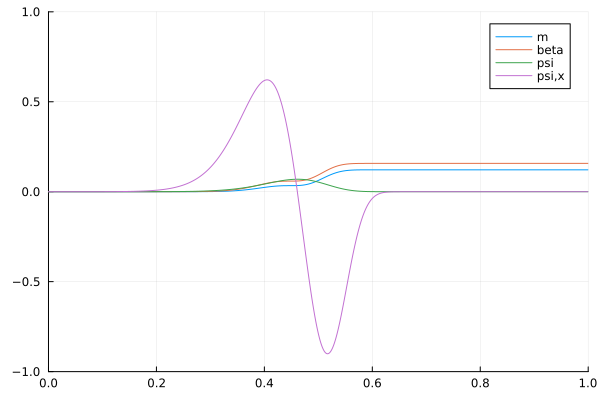

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res3.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res3.gif")
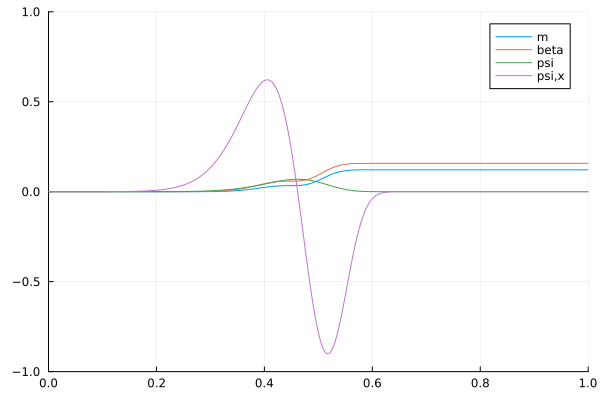

In [1003]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 1:10#length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    d=round(T[n],digits=1)
    #plot!(X1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-0.1,0.1], xlim=[0, 0.1]) |> display 
    plot!(initX[4:L-3], [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1], xlim=[0, 1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 15)

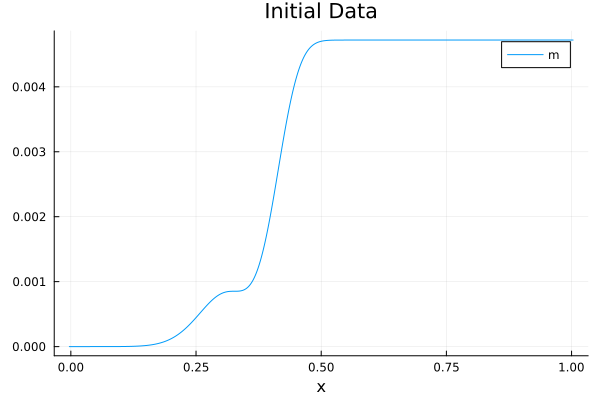

In [308]:
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,initX1,0,spl_funcs)
state_array[:,1]=initm;
state_array=ghost(state_array);

spl_m = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,1],k=4)
m_func(x) = scipyinterpolate.splev(x, spl_m)
spl_funcs[1] = m_func

using Plots #showing initial data and the initial status of the horizon finder
plot(initX, ghost(initm), xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.4, 1])

In [40]:
#monitor_ratio = 1-v/rexp(-2beta)
monitor_ratio = zeros(L)
for i in 1:L
    monitor_ratio = 2*state_array[:,1]/initX[i]*(1-initX[i])
    if monitor_ratio[i]>0.6
        print(monitor_ratio[i])
    end
end